In [114]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
import whma.simulation as simu
from mlpp.base.utils import TimeFunction
from whma.metrics import rel_err, rank_corr, mse_K_partial
from whma.cumulants import get_C, get_K_partial

In [115]:
# simulation of Hawkes processes
d = 10
mu = 0.0005 * np.ones(d)
mus = simu.simulate_mu(d, mu=mu)
blocks = [5,5]
Alpha_truth = np.zeros((d,d))
for i in range(5):
    for j in range(5):
        if i <= j:
            Alpha_truth[i][j] = 1.
for i in range(5,10):
    for j in range(5,10):
        if i >= j:
            Alpha_truth[i][j] = 1.
Alpha_truth /= 6
# add noise
#Alpha_truth += 0.01
blocks = [5,5]
L = []
L.append(np.ones((blocks[0],blocks[0])))
L.append(np.ones((blocks[1],blocks[1])))
Alpha_truth = scipy.linalg.block_diag(*L) / 6
# simplest Alpha possible
Alpha_truth = np.ones((d,d)) / 15

In [116]:
hMax = 40
hDelta = .01
from math import log
beta_min = log(1000) / hMax
beta_max = log(10./9.) / hDelta
print("We have")
print("    beta_min = ",beta_min)
print("    beta_max = ",beta_max)

We have
    beta_min =  0.17269388197455343
    beta_max =  10.536051565782634


In [117]:
LL = []
LL.append(.2*beta_max*np.ones((blocks[0],blocks[0])))
LL.append(10.*beta_min*np.ones((blocks[1],blocks[1])))
Beta = scipy.linalg.block_diag(*LL)
# simplest Beta possible
Beta = np.ones((d,d))

In [118]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.666666666667


In [119]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
T_max = 100000000
h.simulate(T_max)
#estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax, compute_third_moment=True,compute_corr_surf=True,corr_surf_list=[(2,2)])
estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax)

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


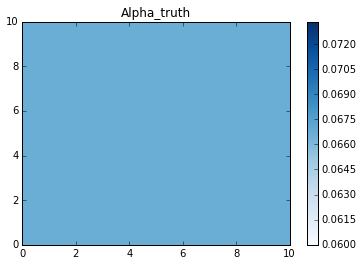

In [120]:
plt.pcolor(Alpha_truth,cmap=plt.cm.Blues)
plt.title("Alpha_truth")
plt.colorbar()
plt.show()
plt.close()
#plt.pcolor(np.array(estim.integrals),cmap=plt.cm.Blues)
#plt.title("integrals")
#plt.colorbar()
#plt.show()
#plt.close()

In [121]:
L = np.array(estim.lam)
C = get_C(estim)

In [122]:
def I2_ij(hk,i,j):
    res = 0.
    if i == j:
        res += len(hk.get_full_process()[i]) / (hk.get_full_process()[i][-1]-hk.get_full_process()[i][0])
    return res

def I1_ij(hk,i,j):
    res = 0
    u = 0
    Z_i = hk.get_full_process()[i]
    Z_j = hk.get_full_process()[j]
    n_j = len(Z_j)
    for tau in Z_i:
        while u < n_j and Z_j[u] < tau:
            u += 1
        res += u
    return res

def I1_ij_alternatif(hk,i,j):
    res = 0
    Z_i = hk.get_full_process()[i]
    Z_j = hk.get_full_process()[j]
    for tau in Z_i:
        res += len(Z_j[Z_j<tau])
    return res

def I3_ij(hk,i,j):
    return I1_ij(hk,j,i)

In [124]:
print(I1_ij(h,3,2))
#print(I1_ij_alternatif(h,3)) # = 11272892542

11259803491


In [125]:
times_i = [1,5,8,12]
times_j = [2,3,9,11,14]

In [204]:
newC = np.zeros((d,d))
T = [x[-1]-x[0] for x in h.get_full_process()]
Tm = max(T)
N = np.array([len(x) for x in h.get_full_process()])
for i in range(d):
    for j in range(d):
        #newC[i,j] = I1_ij(h,i,j) + I3_ij(h,i,j) - N[i]*N[j]
        #newC[i,j] = (.5*N[i]*N[j] - I1_ij(h,j,i)) / (T[j]**2)
        newC[i,j] = I1_ij(h,i,j) / Tm
#newC = newC+newC.T
#newC += np.diag(L)
#print((newC != 0).any())
#newC += np.diag(N)
#print((newC != 0).any())
newC -= np.einsum('i,j->ij',L,L)*Tm

In [205]:
#T_ = h.time
#print(len(h.get_full_process()[3]) / (h.get_full_process()[3][-1]-h.get_full_process()[3][0]))
#print(len(h.get_full_process()[3]) / T_)
#print(estim.lam[3])

In [210]:
from scipy.linalg import inv
R_truth = inv(np.eye(d)-Alpha_truth)
#np.linalg.norm(C)
mat_prod = np.dot(R_truth,np.dot(np.diag(estim.lam),R_truth.T))
print(rel_err(mat_prod,C))
print(rel_err(mat_prod,newC/Tm+np.diag(L)))
print(np.mean(np.diag(mat_prod)))

0.0115484649197
0.945333311743
0.00271021768541


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


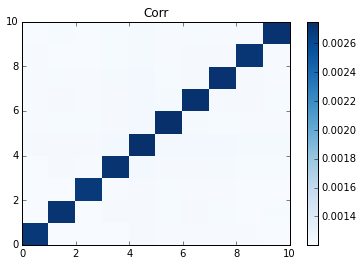

In [180]:
plt.pcolor(C,cmap=plt.cm.Blues)
plt.title("Corr")
plt.colorbar()
plt.show()
plt.close()

In [15]:
def integrated_cumul_estimator():
    pass

In [16]:
tau1 = estim.corr_surf_arrays[0][0]
tau2 = estim.corr_surf_arrays[0][1]
corr = estim.corr_surf_arrays[0][2]

AttributeError: 'Estim' object has no attribute 'corr_surf_arrays'

In [ ]:
tau1_ = np.array([tau1,tau2])
tau2_ = np.array([tau2,tau1])
corr_ = np.array([corr,corr])

In [ ]:
plt.scatter(tau1_[corr_!=0], tau2_[corr_!=0])
plt.show()

In [ ]:
def theoretical_third_cumul(L_,C_,R_,index):
    i,j,k = index
    R_i = R_[i]
    R_j = R_[j]
    R_k = R_[k]
    return np.dot(R_i*R_j,C_[k]) + np.dot(R_i*R_k,C_[j]) + np.dot(R_j*R_k,C_[i]) - 2*np.dot(R_i*R_j*R_k,L_)

# What should I do ?

## I have currently two ways to estimate the volume: using Riemann and Delaunay

## normalize the volume integral to get the expectation

## check if it is close to the theoretical formula with R = R_truth

In [ ]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
hh = hk.Hawkes(kernels=kernels, mus=list(mus))
T_max = 100000
hh.simulate(T_max)
estimm = Estim(hh, n_threads=8)

list_martingale = [np.arange(len(N_i))-estim.lam[i]*N_i for i, N_i in enumerate(hh.get_full_process())]
comp_martingale = np.array(list_martingale)
plt.rcParams['figure.figsize'] = (20.0, 30.0)
f, axes = plt.subplots(10, sharex=True, sharey=True)
for i, axi in enumerate(axes):
    dMi = np.diff(comp_martingale[i])
    axi.hist(dMi,bins=50)
f.subplots_adjust(hspace=0)
#plt.hist(comp_martingale[5],bins=20)